2022-03-31 Ludovico Massaccesi

In [1]:
%matplotlib inline
import numpy as np
import matplotlib.pyplot as plt
import matplotlib.ticker as mticker
from scipy.special import factorial, gammainc

# Frequentist interval estimation
Take a Poisson and compute the lower, upper, and central limits for $n=0,\dots,10$.

In [2]:
# Define the Poisson PMF and CDF

def pmf(n, mu):
    """Poisson PMF."""
    return np.exp(-mu) * mu**n / factorial(n)

def cdf(nmin, nmax, mu):
    """Computes the sum of pmf(n,mu) for n in [nmin,nmax]."""
    return np.sum(pmf(np.arange(nmin, nmax+1), mu))

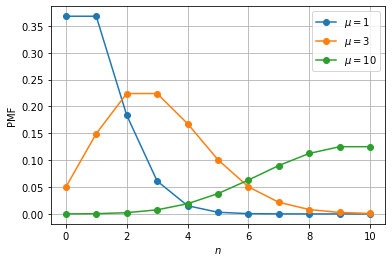

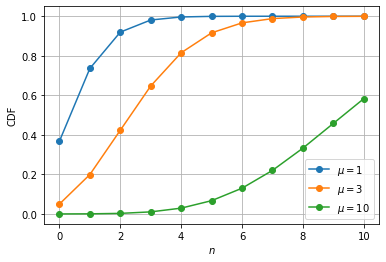

In [3]:
# Check that I wrote them correctly
n = np.arange(11)

plt.figure()
for mu in [1, 3, 10]:
    plt.plot(n, pmf(n, mu), 'o-', label=fr"$\mu={mu:g}$")
plt.grid()
plt.legend()
plt.xlabel("$n$")
plt.ylabel("PMF")
plt.show()

plt.figure()
for mu in [1, 3, 10]:
    plt.plot(n, [cdf(0, i, mu) for i in n], 'o-', label=fr"$\mu={mu:g}$")
plt.grid()
plt.legend()
plt.xlabel("$n$")
plt.ylabel("CDF")
plt.show()

Neyman's bands are defined by requiring that
$$C(\mu)=\sum_{n:o(n)<c}p(n;\mu)\geq CL$$
and solving for $c$, for each value of $\mu$.
The ordering function $o(n)$ is defined by:

1. $o(n)=n$ (sort by $n$ ascending) for the lower limit;
2. $o(n)=-n$ (sort by $n$ descending) for the upper limit;
3. $o(n)=|C(n;\mu)-\frac{1}{2}|$ (sort by distance from the point with cumulant $1/2$ ascending) for the central limit;
4. $o(n)=-P(n;\mu)$ (sort by PMF descending) for the P-ordering limit;
5. $o(n)=-\lambda(n;\mu)=-2\log\frac{p(n;n)}{p(n;\mu)}$ for the likelihood-ratio-ordering limit ($p(n;n)$ is the $\sup_{\mu'}p(n;\mu')$).

Applying this metod directly requires repeating the procedure for a large number of values of $\mu$ in order to obtain high precision limits.
However, the required CPU time increases exponentially with the required precision (number o significant figures).

Since, in a real case, $n$ will be fixed by the observation (and, in this exercise, $n$ takes only a limited number of values), one might try to reverse the problem by fixing the last $n$ that will be included in the band (in the order given by $o$), and solve $C(\mu)=CL$ for $\mu$ numerically.

In [4]:
def find_root(f, x1, x2, precision=1e-7, default=None):
    """Finds x such that f(x) == 0 within precision,
    using the bisection method in the interval [x1,x2]."""
    f1, f2 = f(x1), f(x2)
    if f1 == 0 or f2 == 0:
        #print("INFO One of the extrema is a root.")
        return x1 if f1 == 0 else x2
    if f1 * f2 > 0:
        if default is not None:
            return default
        print("ERROR The function has the same sign at the extrema.")
        print(f"    f({x1}) = {f1}")
        print(f"    f({x2}) = {f2}")
        return np.nan
    x = (x1 + x2) / 2
    while x2-x1 > precision:
        fc = f(x)
        if fc == 0:
            break  # Root found
        if f1 * fc < 0:
            x2 = x
        else:
            x1 = x
        x = (x1 + x2) / 2
        f1, f2 = f(x1), f(x2)
    return x

In [5]:
n_values = list(range(11))
cl = 0.95

In [6]:
%%time
# Lower limit
lower_limits = []
lower_coverage = []
for n in n_values:
    # No need to sort before doing the sum here
    if n == 0:
        mu_min = 0  # mu_min should be < n, no other solution for n=0
    else:
        mu_min = find_root(lambda mu: cdf(0, n, mu) - cl, 0, n)
    lower_limits.append(mu_min)
    lower_coverage.append((0, n, cdf(0, n, mu_min)))

CPU times: user 15.2 ms, sys: 243 µs, total: 15.4 ms
Wall time: 12.7 ms


In [7]:
%%time
# Upper limit
upper_limits = []
upper_coverage = []
for n in n_values:
    # Since the sorting is descending from +∞, so I use
    # 1-SUM_FROM_0_TO_n == CL instead
    # Again, no need to sort
    mu_max = find_root(lambda mu: 1 - cdf(0, n, mu) - cl, n, 5*(n+1))
    upper_limits.append(mu_max)
    upper_coverage.append((n, np.inf, 1 - cdf(0, n, mu_max)))

CPU times: user 25 ms, sys: 11.9 ms, total: 36.9 ms
Wall time: 24.2 ms


In [8]:
%%time
# Central limits
central_limits = []
central_coverage = []
for n in n_values:
    # Here I can find the two limits of the interval
    # separately using SUM_FROM_0_TO_n == (1-CL)/2
    # and 1-SUM_FROM_0_TO_n == (1-CL/2)
    rhs = (1-cl)/2
    if n == 0:
        # mu_min should be < n, no other solution for n=0
        mu_min = 0
    else:
        mu_min = find_root(
            lambda mu: 1 - cdf(0, n, mu) - rhs, 0, 5*(n+1))
    mu_max = find_root(lambda mu: cdf(0, n, mu) - rhs, 0, 5*(n+1))
    central_limits.append((mu_min, mu_max))
    n_min = next(i for i in range(n,-1,-1) if cdf(i, n, mu_min) >= cl)
    n_max = next(i for i in range(n,32) if cdf(n, i, mu_max) >= cl)
    central_coverage.append((
        (n_min, n, cdf(n_min, n, mu_min)),
        (n, n_max, cdf(n, n_max, mu_max))))

CPU times: user 56.9 ms, sys: 4.06 ms, total: 60.9 ms
Wall time: 46.2 ms


In [9]:
%%time
# P-ordering limits

# This time I need to sort the n before summing
N_TO_SORT = list(range(100))
def p_ordered_sum(mu, n_min=0, n_max=np.inf, must_include=-1,
                  stop_at=1, return_lims=False):
    """Computes the sum of p(n;μ) for all the n values,
    sorted by p(n;μ) descending, until a value smaller
    than n_min or larger than n_max is found, or
    must_include is reached, or the sum is > stop_at."""
    N_TO_SORT.sort(key=lambda n: -pmf(n, mu))  # Uses timsort
    s = 0.0
    nlow, nup = np.inf, 0
    for n in N_TO_SORT:
        if n < n_min or n > n_max:
            break
        s += pmf(n, mu)
        nlow, nup = min(nlow, n), max(nup, n)
        if n == must_include or s >= stop_at:
            break
    if return_lims:
        return s, nlow, nup
    return s

p_limits = []
p_coverage = []
for n in n_values:
    if n == 0:
        # mu_min should be < n, no other solution for n=0
        mu_min = 0
        mu_max = find_root(
            lambda mu: p_ordered_sum(mu, must_include=0) - cl, 1, 5)
    else:
        mu_min = find_root(
            lambda mu: p_ordered_sum(mu, n_max=n) - cl, 0, n)
        mu_max = find_root(
            lambda mu: p_ordered_sum(mu, n_min=n) - cl, n, 5*(n+1))
    c_min, n_min, _ = p_ordered_sum(
        mu_min, n_max=n, stop_at=cl, return_lims=True)
    c_max, _, n_max = p_ordered_sum(
        mu_max, n_min=n, stop_at=cl, return_lims=True)
    p_limits.append((mu_min, mu_max))
    p_coverage.append((
        (n_min, n, c_min),
        (n, n_max, c_max)))

CPU times: user 517 ms, sys: 3.74 ms, total: 521 ms
Wall time: 519 ms


In [10]:
%%time
# LR-ordering limits

# Log-likelihood ratio
def llr(n, mu):
    if n == 0:
        return -2 * mu
    if mu == 0:
        return -np.inf
    return 2 * (n * (1 + np.log(mu) - np.log(n)) - mu)

# This time I need to sort the n before summing
def lr_ordered_sum(mu, n_min=0, n_max=np.inf, must_include=-1,
                   stop_at=1, return_lims=False):
    """Computes the sum of p(n;μ) for all the n values,
    sorted by λ(n;μ) descending, until a value smaller
    than n_min or larger than n_max is found, or
    must_include is reached, or the sum is > stop_at."""
    N_TO_SORT.sort(key=lambda n: -llr(n, mu))  # Uses timsort
    s = 0.0
    nlow, nup = np.inf, 0
    for n in N_TO_SORT:
        if n < n_min or n > n_max:
            break
        s += pmf(n, mu)
        nlow, nup = min(nlow, n), max(nup, n)
        if n == must_include or s >= stop_at:
            break
    if return_lims:
        return s, nlow, nup
    return s

lr_limits = []
lr_coverage = []
for n in n_values:
    if n == 0:
        # mu_min should be < n, no other solution for n=0
        mu_min = 0
        mu_max = find_root(
            lambda mu: lr_ordered_sum(mu, must_include=0) - cl, 1, 5)
    else:
        mu_min = find_root(
            lambda mu: lr_ordered_sum(mu, n_max=n) - cl, 0, n)
        mu_max = find_root(
            lambda mu: lr_ordered_sum(mu, n_min=n) - cl, n, 5*(n+1))
    c_min, n_min, _ = lr_ordered_sum(
        mu_min, n_max=n, stop_at=cl, return_lims=True)
    c_max, _, n_max = lr_ordered_sum(
        mu_max, n_min=n, stop_at=cl, return_lims=True)
    lr_limits.append((mu_min, mu_max))
    lr_coverage.append((
        (n_min, n, c_min),
        (n, n_max, c_max)))

CPU times: user 617 ms, sys: 0 ns, total: 617 ms
Wall time: 614 ms


In [11]:
print(" N     lower       upper           central               p-ordering            lr-ordering     ")
print("-----------------------------------------------------------------------------------------------")
for n, l, u, (c1, c2), (p1, p2), (lr1, lr2) in zip(
    n_values, lower_limits, upper_limits, central_limits, p_limits, lr_limits):
    print(f"{n:2d}  {l:10.7f}  {u:10.7f}  {c1:10.7f} {c2:10.7f}  {p1:10.7f} {p2:10.7f}  {lr1:10.7f} {lr2:10.7f}")

 N     lower       upper           central               p-ordering            lr-ordering     
-----------------------------------------------------------------------------------------------
 0   0.0000000   2.9957322   0.0000000  3.6888794   0.0000000  2.9937952   0.0000000  1.1036383
 1   0.3553615   4.7438645   0.2422092  5.5716434   0.3553615  3.7643506   0.3553615  3.0925146
 2   0.8176915   6.2957937   0.6186721  7.2246876   0.8176915  5.7559309   0.8176915  5.1432481
 3   1.3663184   7.7536565   1.0898654  8.7672731   1.3663184  7.2949573   1.3663184  6.7212694
 4   1.9701495   9.1535190   1.6234864 10.2415887   1.9701495  8.8076970   1.8393972  8.2516211
 5   2.6130148  10.5130349   2.2018943 11.6683321   2.6130148 10.3072514   2.2072766  9.7612375
 6   3.2853156  11.8423957   2.8143631 13.0594740   3.2853156 11.7991563   2.5751561 11.2596448
 7   3.9808228  13.1481138   3.4538322 14.4226753   3.7643506 13.2861992   2.9430355 12.7512286
 8   4.6952275  14.4346497   4.1153731 1

In [12]:
def my_plot(limits, coverages, title, fine_bands):
    fig, ax = plt.subplots()
    if isinstance(limits[0], tuple):
        # Unpack stuff
        l_mu = [x[0] for x in limits]
        u_mu = [x[1] for x in limits]
        l_l_n = [x[0][0] for x in coverages]
        l_u_n = [x[0][1] for x in coverages]
        l_cov = [x[0][2] for x in coverages]
        u_l_n = [x[1][0] for x in coverages]
        u_u_n = [x[1][1] for x in coverages]
        u_cov = [x[1][2] for x in coverages]
        # Then make single sequences
        mu = l_mu + u_mu
        l_n = l_l_n + u_l_n
        u_n = l_u_n + u_u_n
        cov = l_cov + u_cov
    else:
        mu = limits[:]
        l_n = [x[0] for x in coverages]
        u_n = [x[1] for x in coverages]
        cov = [x[2] for x in coverages]
    # Sort by mu
    l_n = [x for _, x in sorted(zip(mu, l_n))]
    u_n = [x for _, x in sorted(zip(mu, u_n))]
    cov = [x for _, x in sorted(zip(mu, cov))]
    mu.sort()
    
    plt.scatter(mu, l_n, c='tab:blue')
    mue = np.linspace(*plt.xlim(), 200)
    if not np.isinf(u_n[0]):
        plt.scatter(mu, u_n, c='tab:blue')
        plt.fill_between(mue, *fine_bands(mue), color='tab:blue', alpha=0.5, step='mid')
        yl, yu = np.min(l_n), np.max(u_n)
    else:
        yl, yu = np.min(l_n), np.max(l_n)
        plt.fill_between(mue, fine_bands(mue)[0], yu, color='tab:blue', alpha=0.5, step='mid')
    plt.xlabel(r"$\mu$")
    plt.ylabel(r"$n$", color='tab:blue')
    plt.ylim(yl, yu)
    plt.xlim(np.min(mu), np.max(mu))
    plt.title(title)
    ax.tick_params(axis='y', labelcolor='tab:blue', color='tab:blue')
    
    ax2 = plt.twinx()
    ax2.plot(mu, cov, '.-', c='tab:red')
    ax2.set_ylim(0.9, 1)
    ax2.yaxis.set_major_locator(mticker.MultipleLocator(0.02))
    ax2.yaxis.set_major_formatter(mticker.StrMethodFormatter("{x:.0%}"))
    ax2.set_ylabel("Coverage", color='tab:red')
    ax2.tick_params(axis='y', labelcolor='tab:red', color='tab:red')
    plt.show()

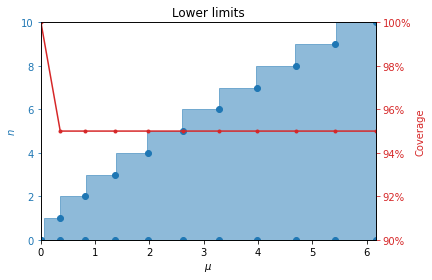

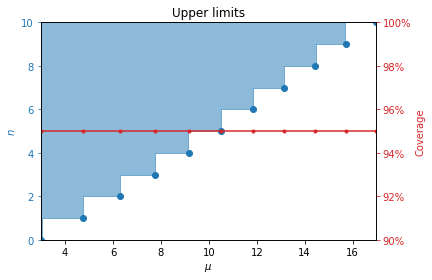

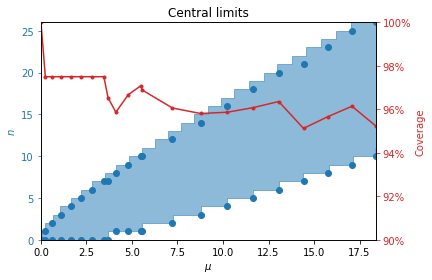

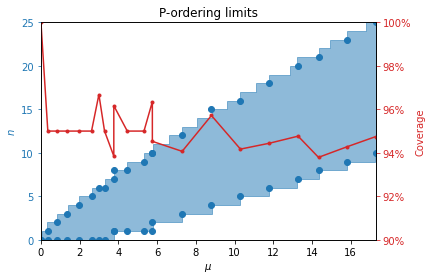

<timed exec>:9: RuntimeWarning: invalid value encountered in log


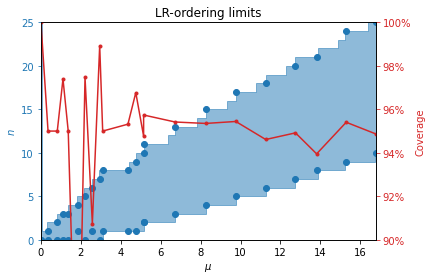

In [13]:
my_plot(lower_limits, lower_coverage, "Lower limits", lambda mu: (
    [0] * len(mu),
    [next(n for n in range(50) if cdf(0, n, m) >= cl) for m in mu]))
my_plot(upper_limits, upper_coverage, "Upper limits", lambda mu: (
    [next(n for n in range(50) if cdf(0, n, m) >= 1-cl) for m in mu],
    [np.inf] * len(mu)))
my_plot(central_limits, central_coverage, "Central limits", lambda mu: (
    [next(n for n in range(50) if cdf(0, n, m) >= (1-cl)/2) for m in mu],
    [next((n for n in range(50) if cdf(0, n, m) >= 1-(1-cl)/2), 0) for m in mu]))
my_plot(p_limits, p_coverage, "P-ordering limits", lambda mu: (
    [next(n for n in range(50,-1,-1) if p_ordered_sum(m, n_min=n) >= cl) for m in mu],
    [next(n for n in range(50) if p_ordered_sum(m, n_max=n) >= cl) for m in mu]))
my_plot(lr_limits, lr_coverage, "LR-ordering limits", lambda mu: (
    [next(n for n in range(50,-1,-1) if lr_ordered_sum(m, n_min=n) >= cl) for m in mu],
    [next(n for n in range(50) if lr_ordered_sum(m, n_max=n) >= cl) for m in mu]))

The actual borders of the Neyman bands should look like step functions. This does not happen in the plots above because only a small number of samples (one for each value of $n$) was computed.

# Bayesian interval estimation
The posterior is defined as
$$\pi_n(\mu)=\pi(\mu)\frac{L_n(\mu)}{n(x)}$$
but, since the requirement is to use a constant prior $\pi(\mu)$, it can be rewritten, for ease of computation, as
$$\pi_n(\mu)=\frac{p(n;\mu)}{\text{normalization}}$$
where the normalization constant is defined so that
$$\int_0^\infty \pi_n(\mu)\text d\mu = 1$$

Since the credibility is defined as
$$Cr(n)=\int_{\mu\in f(n)} \pi_n(\mu)\text d\mu$$
and the credibility intervals are obtained by requiring that
$$\forall n,Cr(n)\geq c$$
it is necessary to be able to compute that integral over any given interval, including $[0,\infty)$.

One could approximate the infinite integral using a finite number of $\mu$ values in a range $[0,M]$ whith $M\gg n$, since the probability $p(n;\mu)$ vanishes for fixed $n$ and $\mu\to\infty$.
The $\mu$ values may be chosen using a fixed step, although taking more values at low $\mu$ proves beneficial with $n=0$.

However, this integral can also be computed analytically:
$$\int\pi_n(\mu)\text d\mu=\frac{1}{n!}\int e^{-\mu}\mu^n\text d\mu=-\frac{\Gamma(n+1,\mu)}{n!}+\text{const}$$

In [14]:
def credibility(n, mu_min, mu_max, n_samp=100):
    if mu_min == mu_max:
        return 0
    mus = []
    if mu_min < (n+1)*3:
        mus.append(np.linspace(
            mu_min, min(mu_max, (n+1)*3), n_samp))
    if mu_max > (n+1)*3:
        mus.append(np.linspace(
            max(mu_min, (n+1)*3), mu_max, n_samp))
    mus = np.hstack(mus)
    ps = pmf(n, mus)
    # Trapezoid rule
    return np.sum((ps[:-1] + ps[1:]) * (mus[1:] - mus[:-1]) / 2)

def credibility_analytical(n, mu_min, mu_max):
    return gammainc(n+1, mu_max) - gammainc(n+1, mu_min)

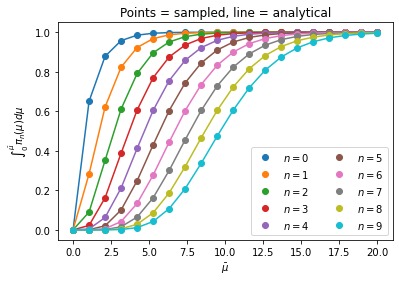

In [15]:
# Compare my function and the analyitical one to check
mu = np.linspace(0, 20, 20)
plt.figure()
plt.title("Points = sampled, line = analytical")
for n in range(10):
    cr = [credibility(n, 0, m) for m in mu]
    cra = [credibility_analytical(n, 0, m) for m in mu]
    plt.plot(mu, cr, 'o', label=f"$n={n}$", c=f'C{n}')
    plt.plot(mu, cra, '-', c=f'C{n}')
plt.xlabel(r"$\bar\mu$")
plt.ylabel(r"$\int_0^{\bar\mu}\pi_n(\mu)d\mu$")
plt.legend(ncol=2)
plt.show()

The normalization factor is clearly 1.

Interval estimation is done by fixing $n$ and solving for $c$ this equation
$$Cr(n)=\int_{\mu:o(\mu)<c}\pi_n(\mu)\text d\mu=C$$
where $C$ is the required credibility level, and the ordering function $o(\mu)$ is:

1. $o(\mu)=-\mu$ (sort by $\mu$ descending) for the lower limit;
2. $o(\mu)=\mu$ (sort by $\mu$ ascending) for the upper limit;
3. the $o(\mu)$ that gives $\int_0^{\mu_{min}}\pi_n(\mu)\text d\mu=\int_{\mu_{max}}^\infty\pi_n(\mu)\text d\mu=\frac{1-C}{2}$ for the central limit;
4. $o(\mu)=-P(n;\mu)$ (sort by PMF descending) for the P-ordering limit.

In this case, fixing $n$ and binary-searching for the right $\mu$s is natural.

In [16]:
n_values = list(range(11))
C = 0.95

In [17]:
%%time
# Lower limit
lower_limits = []
for n in n_values:
    if n == 0:
        mu_min = 0
    else:
        mu_min = find_root(
            lambda mu: 1 - credibility(n, 0, mu) - C, 0.1, n)
    lower_limits.append(mu_min)

CPU times: user 64.6 ms, sys: 5 µs, total: 64.6 ms
Wall time: 55 ms


In [18]:
%%time
# Upper limit
upper_limits = []
for n in n_values:
    mu_max = find_root(
        lambda mu: credibility(n, 0, mu) - C, n, (n+1)*3)
    upper_limits.append(mu_max)

CPU times: user 62.5 ms, sys: 3.99 ms, total: 66.5 ms
Wall time: 58.9 ms


In [19]:
%%time
# Central limits
central_limits_l, central_limits_h = [], []
for n in n_values:
    rhs = (1-C)/2
    if n == 0:
        mu_min = 0
    else:
        mu_min = find_root(
            lambda mu: credibility(n, 0, mu) - rhs, 0, n)
    mu_max = find_root(
        lambda mu: 1 - credibility(n, 0, mu) - rhs, n, (n+1)*4)
    central_limits_l.append(mu_min)
    central_limits_h.append(mu_max)

CPU times: user 128 ms, sys: 20.2 ms, total: 148 ms
Wall time: 128 ms


In [20]:
%%time
# P-ordering limits
mu_min, mu_max = 0, 0
def p_cred(n, min_p):
    """Returns the credibility over the interval [mu1,mu2],
    where p(n;mu1)=p(n;mu2)=min_p."""
    global mu_min, mu_max
    if n == 0:
        mu_min = 0
    else:
        mu_min = find_root(
            lambda mu: pmf(n, mu) - min_p, 0, n, default=0)
    mu_max = find_root(
        lambda mu: pmf(n, mu) - min_p, n, (n+1)*4, default=(n+1)*4)
    return credibility(n, mu_min, mu_max)

p_limits_l, p_limits_h = [], []
for n in n_values:
    min_p = find_root(lambda p: p_cred(n, p) - C, 0, pmf(n, n))
    p_limits_l.append(mu_min)
    p_limits_h.append(mu_max)

CPU times: user 386 ms, sys: 12.3 ms, total: 398 ms
Wall time: 367 ms


In [21]:
%%time
# LR-ordering limits
mu_min, mu_max = 0, 0
def llr_cred(n, min_llr):
    """Returns the credibility over the interval [mu1,mu2],
    where λ(n;mu1)=λ(n;mu2)=min_llr."""
    global mu_min, mu_max
    if n == 0:
        mu_min = 0
    else:
        mu_min = find_root(
            lambda mu: llr(n, mu) - min_llr, 0, n, default=0)
    mu_max = find_root(
        lambda mu: llr(n, mu) - min_llr, n, (n+1)*4, default=(n+1)*4)
    return credibility(n, mu_min, mu_max)

lr_limits_l, lr_limits_h = [], []
for n in n_values:
    min_llr = find_root(lambda llr: llr_cred(n, llr) - C, -10, 0)
    lr_limits_l.append(mu_min)
    lr_limits_h.append(mu_max)

CPU times: user 566 ms, sys: 20.4 ms, total: 587 ms
Wall time: 544 ms


In [22]:
print(" N     lower       upper           central               p-ordering            lr-ordering     ")
print("-----------------------------------------------------------------------------------------------")
for n, l, u, c1, c2, p1, p2, lr1, lr2 in zip(
    n_values, lower_limits, upper_limits, central_limits_l, central_limits_h,
    p_limits_l, p_limits_h, lr_limits_l, lr_limits_h):
    print(f"{n:2d}  {l:10.7f}  {u:10.7f}  {c1:10.7f} {c2:10.7f}  {p1:10.7f} {p2:10.7f}  {lr1:10.7f} {lr2:10.7f}")

 N     lower       upper           central               p-ordering            lr-ordering     
-----------------------------------------------------------------------------------------------
 0   0.0000000   2.9942851   0.0000000  3.6859712   0.0000000  2.9942847   0.0000000  2.9942850
 1   0.3553639   4.7486668   0.2422104  5.5844337   0.0422132  4.7694699   0.0422132  4.7694712
 2   0.8176832   6.2960254   0.6186648  7.2250148   0.3032832  6.4029894   0.3032830  6.4029915
 3   1.3662994   7.7539683   1.0898476  8.7676981   0.7122238  7.9497253   0.7122235  7.9497262
 4   1.9701156   9.1539201   1.6234536 10.2421322   1.2066302  9.4315430   1.2066289  9.4315481
 5   2.6129617  10.5135277   2.2018419 11.6689936   1.7577006 10.8657434   1.7576988 10.8657495
 6   3.2852399  11.8429839   2.8142868 13.0602579   2.3498058 12.2636445   2.3498058 12.2636448
 7   3.9807206  13.1488011   3.4537281 14.4235855   2.9733943 13.6328322   2.9733940 13.6328331
 8   4.6950956  14.4354394   4.1152372 1

The Bayesian limits in the above table are very close to to the frequentist limits obtained before, except for those obtained with the P-ordering and the LR-ordering. The Bayesian results obtained with the P-ordering and the LR-ordering are similar. All results are reported here for ease of comparison.

|$n$|Method|Lower|Upper|Central|P-ordering|LR-ordering|
|:-:|:-:|:-:|:-:|:-:|:-:|:-:|
|0|Bayes|0.0000000|2.9942851|0.0000000 - 3.6859712|0.0000000 - 2.9942847|0.0000000 - 2.9942850|
||freq.|0.0000000|2.9957322|0.0000000 - 3.6888794|0.0000000 - 2.9937952|0.0000000 - 1.1036383|
|1|Bayes|0.3553639|4.7486668|0.2422104 - 5.5844337|0.0422132 - 4.7694699|0.0422132 - 4.7694712|
||freq.|0.3553615|4.7438645|0.2422092 - 5.5716434|0.3553615 - 3.7643506|0.3553615 - 3.0925146|
|2|Bayes|0.8176832|6.2960254|0.6186648 - 7.2250148|0.3032832 - 6.4029894|0.3032830 - 6.4029915|
||freq.|0.8176915|6.2957937|0.6186721 - 7.2246876|0.8176915 - 5.7559309|0.8176915 - 5.1432481|
|3|Bayes|1.3662994|7.7539683|1.0898476 - 8.7676981|0.7122238 - 7.9497253|0.7122235 - 7.9497262|
||freq.|1.3663184|7.7536565|1.0898654 - 8.7672731|1.3663184 - 7.2949573|1.3663184 - 6.7212694|
|4|Bayes|1.9701156|9.1539201|1.6234536 - 10.2421322|1.2066302 - 9.4315430|1.2066289 - 9.4315481|
||freq.|1.9701495|9.1535190|1.6234864 - 10.2415887|1.9701495 - 8.8076970|1.8393972 - 8.2516211|
|5|Bayes|2.6129617|10.5135277|2.2018419 - 11.6689936|1.7577006 - 10.8657434|1.7576988 - 10.8657495|
||freq.|2.6130148|10.5130349|2.2018943 - 11.6683321|2.6130148 - 10.3072514|2.2072766 - 9.7612375|
|6|Bayes|3.2852399|11.8429839|2.8142868 - 13.0602579|2.3498058 - 12.2636445|2.3498058 - 12.2636448|
||freq.|3.2853156|11.8423957|2.8143631 - 13.0594740|3.2853156 - 11.7991563|2.5751561 - 11.2596448|
|7|Bayes|3.9807206|13.1488011|3.4537281 - 14.4235855|2.9733943 - 13.6328322|2.9733940 - 13.6328331|
||freq.|3.9808228|13.1481138|3.4538322 - 14.4226753|3.7643506 - 13.2861992|2.9430355 - 12.7512286|
|8|Bayes|4.6950956|14.4354394|4.1152372 - 15.7642296|3.6221250 - 14.9786389|3.6221232 - 14.9786436|
||freq.|4.6952275|14.4346497|4.1153731 - 15.7631892|4.4601431 - 14.3402175|4.3574091 - 13.8106154|
|9|Bayes|5.4252408|15.7061118|4.7952173 - 17.0859777|4.2915338 - 16.3049605|4.2915330 - 16.3049625|
||freq.|5.4254057|15.7052164|4.7953887 - 17.0848035|5.3233211 - 15.8197301|4.7513457 - 15.2924612|
|10|Bayes|6.1688064|16.9632233|5.4909499 - 18.3916678|4.9783454 - 17.6147171|4.9783445 - 17.6147192|
||freq.|6.1690073|16.9622192|5.4911603 - 18.3903560|5.7559309 - 17.2978262|5.1432481 - 16.7723993|


In [23]:
def my_plot_b(n, ll=None, ul=None, title=""):
    if ll is None:
        ll = [0] * len(ul)
    elif ul is None:
        ul = [np.inf] * len(ll)
    
    fig, ax = plt.subplots()
    plt.scatter(n, ll, c='tab:blue')
    if not np.isinf(ul[0]):
        plt.scatter(n, ul, c='tab:blue')
        for a, b, c in zip(n, ll, ul):
            plt.plot([a,a], [b,c], '-', c='tab:blue', alpha=0.5)
        yl, yu = np.min(ll), np.max(ul)
    else:
        yl, yu = np.min(ll), np.max(ll)
        for a, b in zip(n, ll):
            plt.plot([a,a], [b,yu], '-', c='tab:blue', alpha=0.5)
    plt.xlabel("$n$")
    plt.ylabel(r"$\mu$", color='tab:blue')
    plt.ylim(yl, yu)
    plt.xlim(np.min(n), np.max(n))
    plt.title(title)
    ax.tick_params(axis='y', labelcolor='tab:blue', color='tab:blue')
    
    ax2 = plt.twinx()
    if not np.isinf(ul[0]):
        cr = [credibility(*itm) for itm in zip(n, ll, ul)]
    else:
        cr = [1-credibility(a, 0, b) for a, b in zip(n, ll)]
    ax2.plot(n, cr, '.-', c='tab:red')
    ax2.set_ylim(0.9, 1)
    ax2.yaxis.set_major_locator(mticker.MultipleLocator(0.02))
    ax2.yaxis.set_major_formatter(mticker.StrMethodFormatter("{x:.0%}"))
    ax2.set_ylabel("Credibility", color='tab:red')
    ax2.tick_params(axis='y', labelcolor='tab:red', color='tab:red')
    plt.show()

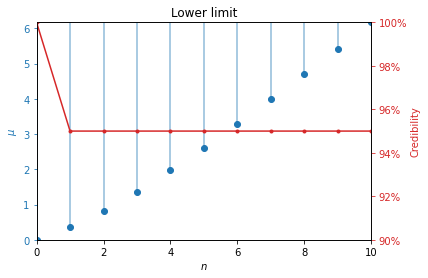

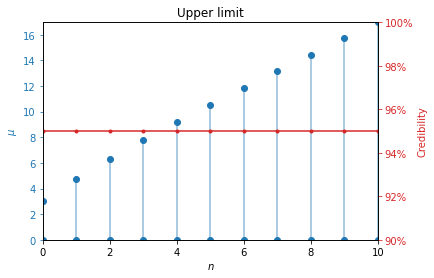

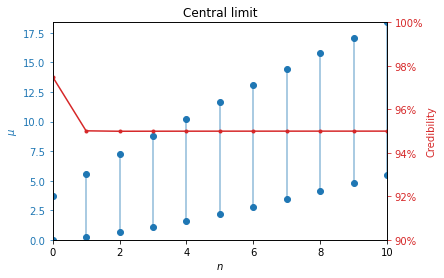

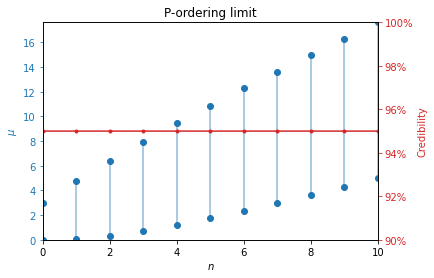

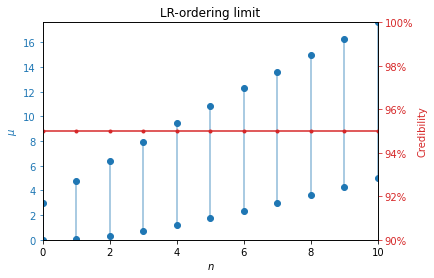

In [24]:
my_plot_b(n_values, lower_limits, title="Lower limit")
my_plot_b(n_values, ul=upper_limits, title="Upper limit")
my_plot_b(n_values, central_limits_l, central_limits_h,
          title="Central limit")
my_plot_b(n_values, p_limits_l, p_limits_h, title="P-ordering limit")
my_plot_b(n_values, lr_limits_l, lr_limits_h, title="LR-ordering limit")